#### T2D 치료 조건 간 Beta-cell 반응 프로그램 차이 추출

< cNMF로 추출한 gene program(components)이 T2D의 다양한 treatment group 간에 어떤 차이를 보이는가 >
- k = 9로 결정됨 (k_selection.png 참고)
- usages : 각 cell × 10개 프로그램 활성도 행렬 (각 cell별 각 program 사용량)
- gene_spectra_score : 각 program에 기여한 유전자 (gene loading matrix, 프로그램별로 유전자 가중치)

In [18]:
import pandas as pd
import scanpy as sc
from scipy.stats import f_oneway
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal
import numpy as np

##### 1. Data loading & processing

In [3]:
# cNMF 결과 usage matrix (cells × programs)
usages = pd.read_csv("C:/Users/user/Desktop/T1D/t2d_treatment/cnmf_output/t2d_cnmf/t2d_cnmf.usages.k_9.dt_0_01.consensus.txt", sep="\t", index_col=0)
print(usages.shape)  # (cells, programs) = (4532, 9)
print(usages)

(4532, 9)
                                        1         2         3         4  \
index                                                                     
TGGCGTGCAAGATGTA-1-MUC13641-VSG  0.000000  0.137286  0.841368  0.000000   
GTTTACTAGCCACCGT-1-MUC13641-VSG  0.000000  1.080015  0.022209  0.000000   
TATTCCATCGGACCAC-1-MUC13641-VSG  0.000000  0.026314  0.000000  0.006894   
CGTAGTAGTCATTGCA-1-MUC13639-VSG  1.065110  0.032195  0.006279  0.001211   
TCAAGCACAACGACTT-1-MUC13641-VSG  0.000000  0.967041  0.029055  0.011750   
...                                   ...       ...       ...       ...   
CTCTACGCATCACCCT-1-G3-STZ        0.402319  0.002312  0.008662  0.002272   
TCTGGAAAGAACAACT-1-G3-STZ        1.633898  0.002404  0.002739  0.018726   
GAATAAGCACGTTGGC-1-G3-STZ        1.968783  0.023298  0.001433  0.007613   
TACACGAAGGATATAC-1-G3-STZ        1.008599  0.013883  0.009595  0.011934   
CCGGTAGAGAGCTTCT-1-G3-STZ        0.364053  0.026591  0.004302  0.006534   

              

In [4]:
df = pd.read_csv("C:/Users/user/Desktop/T1D/t2d_treatment/cnmf_data.txt", sep="\t", index_col=0)
adata = sc.AnnData(df)

In [ ]:
# AnnData에 usage matrix를 붙이기 (-> downstream에서 UMAP 등으로 시각화 가능)
adata.obsm["X_cnmf"] = usages.values

# adata.obsm["X_cnmf"]
# array([[0.00000000e+00, 1.37286048e-01, 8.41367564e-01, ...,
#         0.00000000e+00, 0.00000000e+00, 1.05609606e-03],
#        [0.00000000e+00, 1.08001468e+00, 2.22094097e-02, ...,
#         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
#        [0.00000000e+00, 2.63138445e-02, 0.00000000e+00, ...,
#         2.34861795e-02, 2.20539433e-02, 4.70754140e-02],
#        ...,
#        [1.96878277e+00, 2.32976727e-02, 1.43331492e-03, ...,
#         9.64759657e-03, 3.73749625e-03, 6.54978014e-03],
#        [1.00859940e+00, 1.38828124e-02, 9.59514797e-03, ...,
#         6.35203805e-03, 0.00000000e+00, 3.96509892e-04],
#        [3.64052742e-01, 2.65906742e-02, 4.30222059e-03, ...,
#         1.98109784e-03, 3.03196083e-03, 1.01271654e-03]], shape=(4532, 9))

In [ ]:
# treatment 정보를 adata.obs['condition']로 정리
adata_filter = sc.read_h5ad('C:/Users/user/Desktop/T1D/t2d_treatment_filtered.h5ad')

# adata_filter.obs['condition']
# index
# TGGCGTGCAAGATGTA-1-MUC13641-VSG                   T2D_db/db
# GTTTACTAGCCACCGT-1-MUC13641-VSG                   T2D_db/db
# TATTCCATCGGACCAC-1-MUC13641-VSG                   T2D_db/db
# CGTAGTAGTCATTGCA-1-MUC13639-VSG                   T2D_db/db
# TCAAGCACAACGACTT-1-MUC13641-VSG                   T2D_db/db
#                                              ...           
# CTCTACGCATCACCCT-1-G3-STZ          T2D_mSTZ-treated_insulin
# TCTGGAAAGAACAACT-1-G3-STZ          T2D_mSTZ-treated_insulin
# GAATAAGCACGTTGGC-1-G3-STZ          T2D_mSTZ-treated_insulin
# TACACGAAGGATATAC-1-G3-STZ          T2D_mSTZ-treated_insulin
# CCGGTAGAGAGCTTCT-1-G3-STZ          T2D_mSTZ-treated_insulin
# Name: condition, Length: 4532, dtype: category
# Categories (7, object): ['T2D_db/db', 'T2D_mSTZ', 'T2D_mSTZ-treated_GLP-1', 'T2D_mSTZ-treated_GLP-1_estrogen', 'T2D_mSTZ-treated_GLP-1_estrogen+insulin', 'T2D_mSTZ-treated_estrogen', 'T2D_mSTZ-treated_insulin']

index
TGGCGTGCAAGATGTA-1-MUC13641-VSG                   T2D_db/db
GTTTACTAGCCACCGT-1-MUC13641-VSG                   T2D_db/db
TATTCCATCGGACCAC-1-MUC13641-VSG                   T2D_db/db
CGTAGTAGTCATTGCA-1-MUC13639-VSG                   T2D_db/db
TCAAGCACAACGACTT-1-MUC13641-VSG                   T2D_db/db
                                             ...           
CTCTACGCATCACCCT-1-G3-STZ          T2D_mSTZ-treated_insulin
TCTGGAAAGAACAACT-1-G3-STZ          T2D_mSTZ-treated_insulin
GAATAAGCACGTTGGC-1-G3-STZ          T2D_mSTZ-treated_insulin
TACACGAAGGATATAC-1-G3-STZ          T2D_mSTZ-treated_insulin
CCGGTAGAGAGCTTCT-1-G3-STZ          T2D_mSTZ-treated_insulin
Name: condition, Length: 4532, dtype: category
Categories (7, object): ['T2D_db/db', 'T2D_mSTZ', 'T2D_mSTZ-treated_GLP-1', 'T2D_mSTZ-treated_GLP-1_estrogen', 'T2D_mSTZ-treated_GLP-1_estrogen+insulin', 'T2D_mSTZ-treated_estrogen', 'T2D_mSTZ-treated_insulin']

In [9]:
# [확인] 개수 및 중복 여부
print(set(adata.obs_names) & set(adata_filter.obs_names))
print(len(adata.obs_names))   # 4532
print(len(adata_filter.obs_names))   # 4532

{'AAATGCCCAATACGCT-1-G6-STZ', 'TGAGCCGTCAAGGCTT-1-G2-STZ', 'TTGACCCTCCAGCACG-1-MUC13639-VSG', 'ACCTTTAGTGTGGCTC-1-G6-STZ', 'AAGATAGGTCAAAGCG-1-MUC13639-VSG', 'AACGTTGGTCTCAACA-1-G4-STZ', 'TGCTTGCGTTCGATTG-1-MUC13639-VSG', 'GTTACAGGTTCCACAA-1-MUC13641-VSG', 'CACATAGAGACTTTCG-1-G2-STZ', 'AACGTTGGTCAAAGCG-1-G2-STZ', 'TGCAGATTCTCTTAAC-1-MUC13639-VSG', 'CACAGGCCAGGAACGT-1-G5-STZ', 'ATTATCCAGTAGGTGC-1-G8-STZ', 'ACTGAGTTCTCTAAGG-1-G3-STZ', 'GCTTCCACAAGAGTCG-1-G5-STZ', 'TCTTAGTGTCACTAGT-1-MUC13639-VSG', 'AGTACCAAGATACGAT-1-MUC13641-VSG', 'ACGTACAAGCGATCGA-1-MUC13639-VSG', 'TCTTTGAGTGAGTAAT-1-MUC13641-VSG', 'AGAGCTTCAACTGGCC-1-G5-STZ', 'AGTCTTTAGGGCATGT-1-G3-STZ', 'GAATGAAAGTCTTGCA-1-G2-STZ', 'GATGCTATCACCGCTT-1-MUC13639-VSG', 'TCTCATAAGATATACG-1-G8-STZ', 'GTGTAACTCCACACCT-1-MUC13641-VSG', 'GGCTTGGGTTTACCTT-1-MUC13641-VSG', 'CTGAAACCATGTAGTC-1-G6-STZ', 'TATCAGGTCTGAGGGA-1-G4-STZ', 'GGTGTTACAGTATGCT-1-G4-STZ', 'CCGGGATCAATAAGCA-1-G3-STZ', 'CGGGTCAGTCTGCCAG-1-G3-STZ', 'CATGGCGCAGTGGAGT-1-G5-STZ',

In [11]:
# adata_filter condition 정보 추출
condition_map = adata_filter.obs['condition']
# 공통된 cell id 기준으로 adata.obs에 condition 할당
adata.obs['condition'] = condition_map.reindex(adata.obs_names).values
# reindex(): adata.obs_names 순서에 맞게 값을 정렬하고, 없는 값은 NaN으로 처리
print(adata.obs['condition'].value_counts(dropna=False))

condition
T2D_db/db                                  1239
T2D_mSTZ-treated_GLP-1_estrogen             794
T2D_mSTZ                                    746
T2D_mSTZ-treated_estrogen                   588
T2D_mSTZ-treated_GLP-1                      505
T2D_mSTZ-treated_GLP-1_estrogen+insulin     343
T2D_mSTZ-treated_insulin                    317
Name: count, dtype: int64


In [12]:
# [확인] shape
print(adata.obsm["X_cnmf"].shape)  # (cells, programs)

(4532, 9)


##### usage clustering/패턴 분포 시각화

- cell-level 시각화 : 각 세포가 어떤 program을 많이 사용하는가 (cnmf_program 기준)
- program-level 분석 : 각 program이 어떤 유전자로 구성되어 있고, 어떤 생물학적 기능을 가지는가 (spectra(gene loadings), top genes 기준)

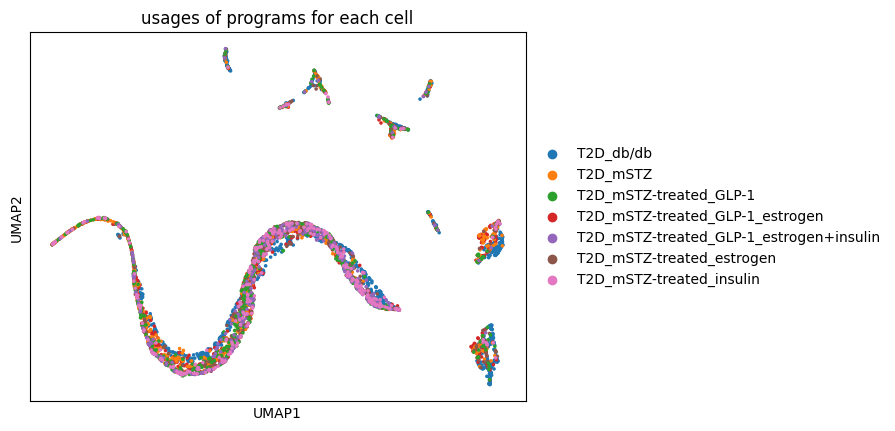

In [ ]:
sc.pp.neighbors(adata, use_rep="X_cnmf", n_neighbors=30, n_pcs=9)
sc.tl.umap(adata, min_dist=0.2, spread=1.5)
sc.pl.umap(adata, color='condition', title='usages of programs for each cell')

# 하이퍼파라미터 수정 계속 하였지만, 클러스터링 안 됨.

C:\Users\user\AppData\Local\Temp\ipykernel_2664\3777416532.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  usage_m = usage.groupby('condition').mean()


<Axes: ylabel='condition'>

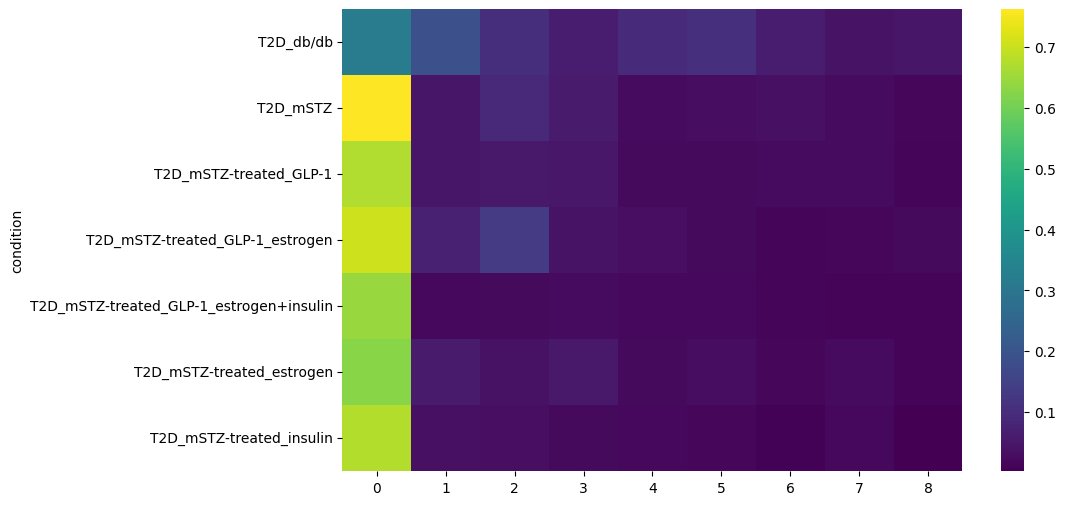

In [17]:
# usage 자체의 차이 여부 확인
usage = pd.DataFrame(adata.obsm["X_cnmf"])
usage['condition'] = adata.obs['condition'].values
usage_m = usage.groupby('condition').mean()

plt.figure(figsize=(10,6))
sns.heatmap(usage_m, cmap='viridis')

# 조건 별로 program 사용량 평균의 차이가 없으면 UMAP 시각화해도 잘 안 나옴.

- component 0: T2D_mSTZ에서 매우 높고, db/db는 중간, 나머지는 낮음.

In [ ]:
# X_cnmf의 정규화 필요 여부
X = adata.obsm["X_cnmf"]
row_sums = X.sum(axis=1)
print(np.min(row_sums), np.max(row_sums))  # 모두 거의 1.0 근처여야 함.

# X_cnmf가 normalized되어 있지 않으면, UMAP이 거리 계산에 왜곡을 받음
# usage는 cell 당 합이 1인 확률 분포여야 함.

# 0.22 ~ 2.70 사이로 분포 → scaling이 필요.

0.2237166315061763 2.7012997962945513


c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\scanpy\preprocessing\_pca\__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(adata, mask_var, use_highly_variable)


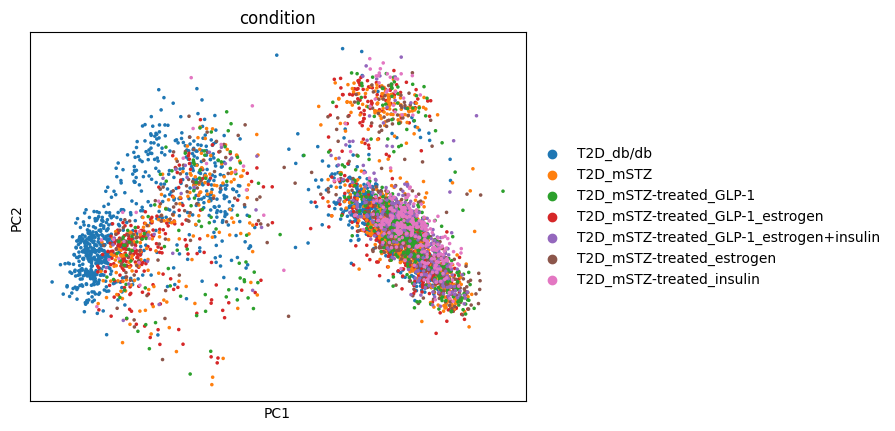

In [ ]:
# [UMAP X] PCA 시각화
sc.pp.pca(adata, use_highly_variable=False, n_comps=10)
sc.pl.pca(adata, color="condition")

# 클러스터링 안 됨..

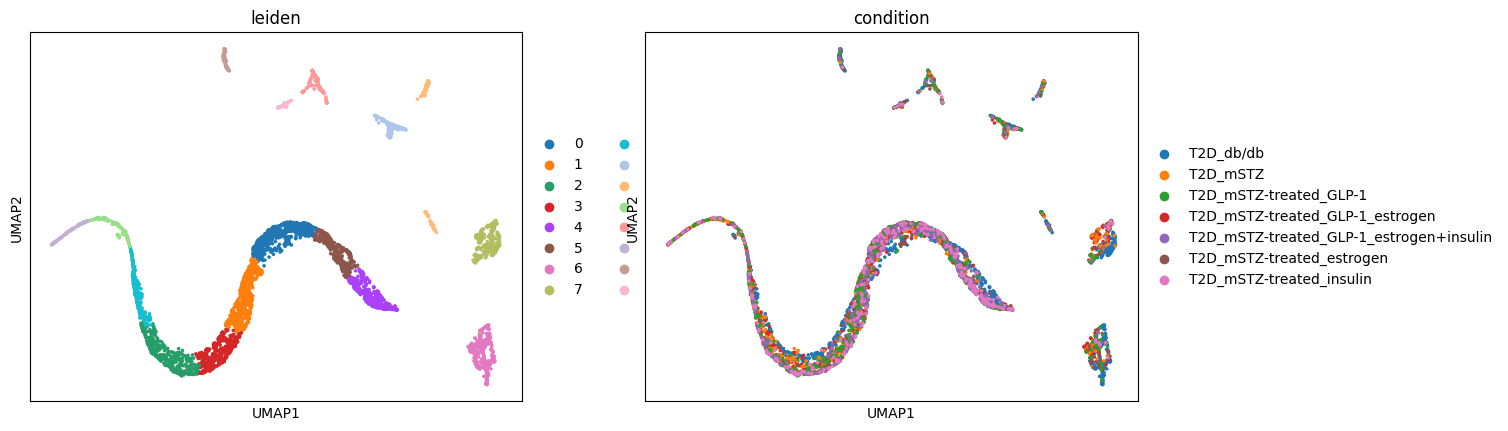

In [21]:
# [UMAP X] Leiden clustering
sc.pp.neighbors(adata, use_rep="X_cnmf", n_neighbors=30)
sc.tl.leiden(adata, resolution=0.5)
sc.pl.umap(adata, color=["leiden", "condition"])

- X_cnmf를 기반 만든 클러스터(좌측 leiden plot)는 군집 분리가 잘 되어 있지만, 각 군집에 다양한 condition이 섞여 있음.

=> 이는 각 treatment condition이 완전히 독립된 program usage를 갖진 않지만, 특정 program 조합에 따라 세포들이 부분적으로 반응 프로그램을 공유할 수 있음을 의미.

In [22]:
# X_cnmf 정규화
# Normalize so that each row sums to 1 (i.e., program usage as probability vector)
X_cnmf = adata.obsm["X_cnmf"]
X_norm = X_cnmf / X_cnmf.sum(axis=1, keepdims=True)
adata.obsm["X_cnmf_norm"] = X_norm

C:\Users\user\AppData\Local\Temp\ipykernel_2664\3830484904.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_usage = usage_df.groupby("condition").mean()


Text(0.5, 1.0, 'Mean program usage per condition')

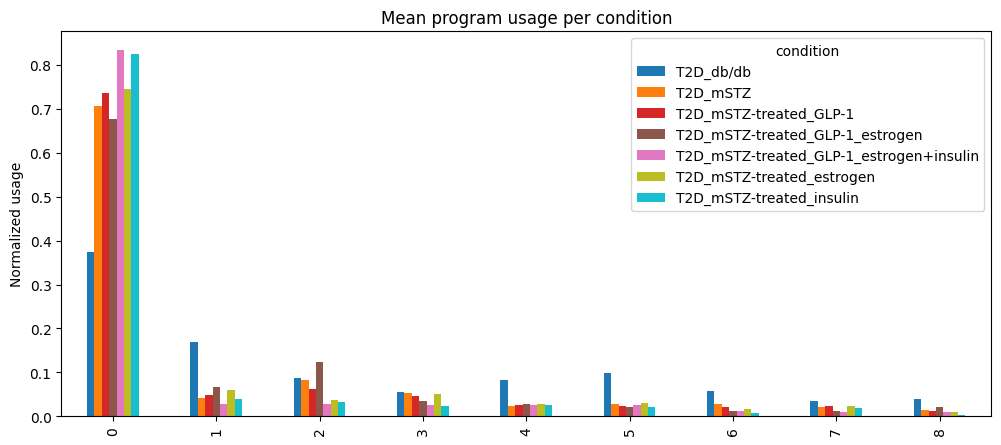

In [ ]:
# 각 program의 condition별 usage(활성도) 비교 (bar plot 사용)

usage_df = pd.DataFrame(adata.obsm["X_cnmf_norm"])
usage_df["condition"] = adata.obs["condition"].values
mean_usage = usage_df.groupby("condition").mean()

mean_usage.T.plot(kind="bar", figsize=(12,5), colormap="tab10")
plt.ylabel("Normalized usage")
plt.title("Mean program usage per condition")

In [24]:
# 각 program에 대해 condition 간 ANOVA or Kruskal-Wallis test (유의미한 프로그램 찾기 → downstream 해석으로 연결)
for i in range(9):  # 9 components
    grouped = [group[i].values for name, group in usage_df.groupby("condition")]
    stat, pval = kruskal(*grouped)
    print(f"Program {i}: p = {pval:.4e}")

Program 0: p = 3.4518e-244
Program 1: p = 7.3378e-144
Program 2: p = 2.5281e-96
Program 3: p = 9.0655e-10
Program 4: p = 1.3012e-85
Program 5: p = 1.2072e-137
Program 6: p = 4.5671e-07
Program 7: p = 1.3306e-07
Program 8: p = 4.9782e-08


C:\Users\user\AppData\Local\Temp\ipykernel_2664\4276044070.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = [group[i].values for name, group in usage_df.groupby("condition")]


Text(0.5, 1.0, 'Condition composition per usage-based cluster')

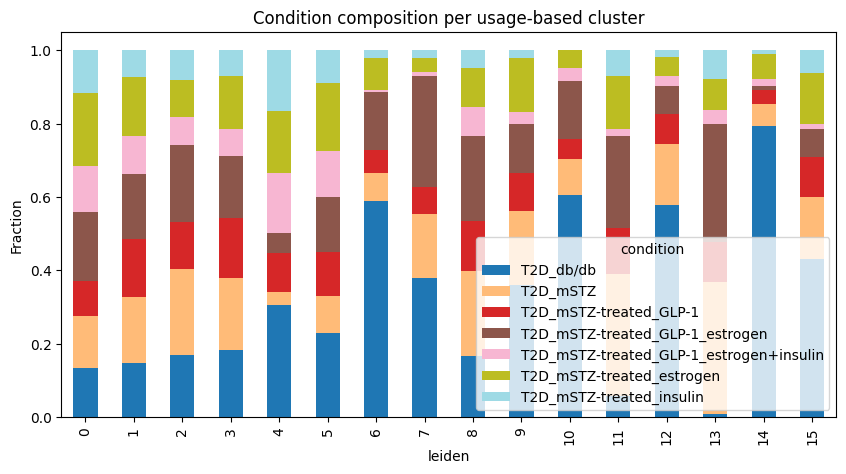

In [25]:
# 클러스터 (leiden)별 condition enrichment
pd.crosstab(adata.obs["leiden"], adata.obs["condition"], normalize='index') \
  .plot(kind='bar', stacked=True, figsize=(10,5), colormap='tab20')
plt.ylabel("Fraction")
plt.title("Condition composition per usage-based cluster")

In [36]:
# (유전자 × program weight) 파일

# gene spectra score: Z-score unit gene expression program matrix
spectra = pd.read_csv("C:/Users/user/Desktop/T1D/t2d_treatment/cnmf_output/t2d_cnmf/t2d_cnmf.gene_spectra_score.k_9.dt_0_01.txt", sep="\t", index_col=0)
print("Shape of score matrix:", spectra.shape)
print("Columns (first 5):", spectra.columns[:5])
# spectra: gene weights per program

Shape of score matrix: (9, 13460)
Columns (first 5): Index(['ENSMUSG00000000001', 'ENSMUSG00000000028', 'ENSMUSG00000000056',
       'ENSMUSG00000000058', 'ENSMUSG00000000078'],
      dtype='object')


In [ ]:
# 유전자 해석 (GO, KEGG 등)
# → Program별로 top-weighted genes 추출 -> gProfiler, Enrichr, DAVID 등에 넣어 pathway 분석

top_n = 30

for i in range(9):
    program_name = f"Program_{i}"
    top_genes = spectra.iloc[:, i].sort_values(ascending=False).head(top_n).index.tolist()
    print(f"{program_name}: {top_genes[:5]}")

# "세포 유형"과 1:1로 매칭되는 게 아닌, 세포들이 공유하는 전사 프로그램(=유전자 발현 패턴)
# functional program 기반 클러스터링임.

Program_0: [6, 5, 2, 4, 8]
Program_1: [5, 3, 6, 2, 7]
Program_2: [7, 3, 2, 4, 5]
Program_3: [4, 8, 6, 9, 2]
Program_4: [6, 9, 5, 7, 4]
Program_5: [1, 8, 6, 4, 7]
Program_6: [5, 3, 6, 9, 2]
Program_7: [8, 4, 9, 2, 3]
Program_8: [8, 7, 1, 9, 4]


In [ ]:
# for each program, extract top 30 genes
for i in spectra.index:  # programs are row indices
    top_gene_indices = spectra.loc[i].argsort()[::-1][:30]
    top_genes = spectra.columns[top_gene_indices].tolist()  # gene names are column names
    print(f"Program {i}: {top_genes[:5]}")   # 각 프로그램 별 상위 5개 대표 유전자들


Program 1: ['ENSMUSG00000027419', 'ENSMUSG00000039278', 'ENSMUSG00000021268', 'ENSMUSG00000023236', 'ENSMUSG00000033061']
Program 2: ['ENSMUSG00000076498', 'ENSMUSG00000002033', 'ENSMUSG00000056290', 'ENSMUSG00000032094', 'ENSMUSG00000032093']
Program 3: ['ENSMUSG00000003379', 'ENSMUSG00000034634', 'ENSMUSG00000024673', 'ENSMUSG00000073421', 'ENSMUSG00000076937']
Program 4: ['ENSMUSG00000029648', 'ENSMUSG00000034845', 'ENSMUSG00000054690', 'ENSMUSG00000062960', 'ENSMUSG00000026921']
Program 5: ['ENSMUSG00000028100', 'ENSMUSG00000031779', 'ENSMUSG00000029581', 'ENSMUSG00000033083', 'ENSMUSG00000040829']
Program 6: ['ENSMUSG00000020911', 'ENSMUSG00000006777', 'ENSMUSG00000025934', 'ENSMUSG00000017723', 'ENSMUSG00000103711']
Program 7: ['ENSMUSG00000019929', 'ENSMUSG00000036446', 'ENSMUSG00000001506', 'ENSMUSG00000026043', 'ENSMUSG00000029661']
Program 8: ['ENSMUSG00000026678', 'ENSMUSG00000020928', 'ENSMUSG00000040280', 'ENSMUSG00000009876', 'ENSMUSG00000021388']
Program 9: ['ENSMUSG0000

[gProfiler URL] https://biit.cs.ut.ee/gprofiler/gost

- organism: Mus musculus
- gene list: 각 program에서 뽑은 top 30 gene
- 선택 옵션: GO Biological Process, KEGG, Reactome

→ 예: Program 0은 inflammation 관련, Program 1은 ER stress 관련 등 해석 가능

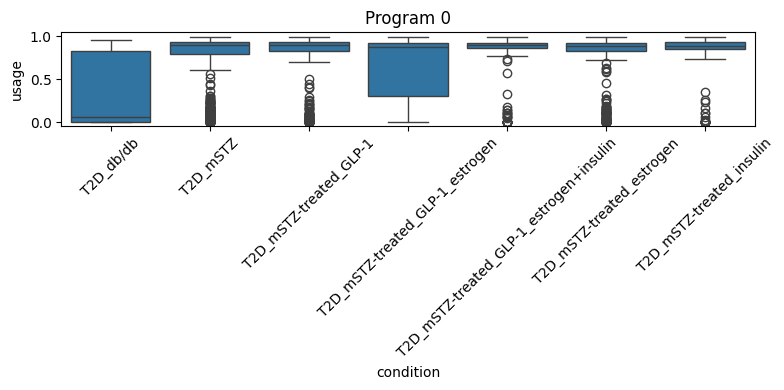

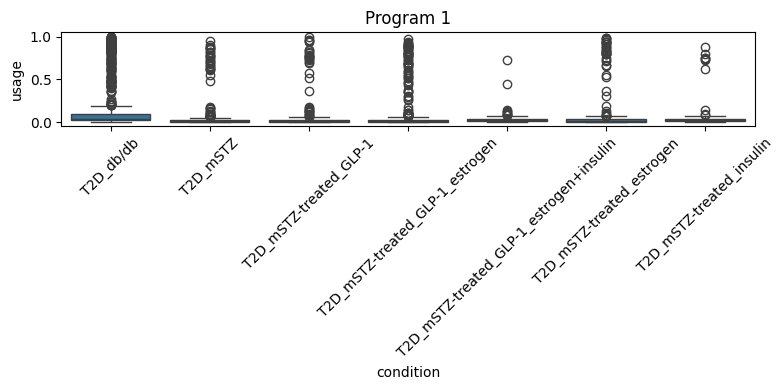

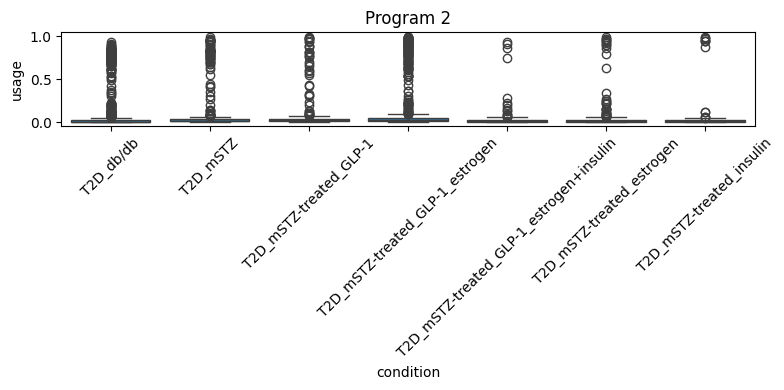

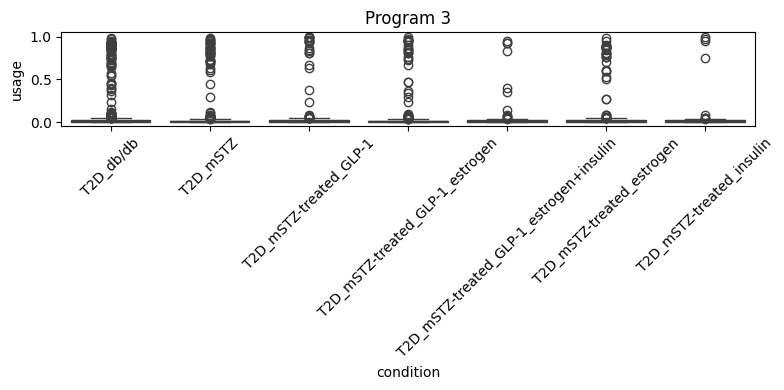

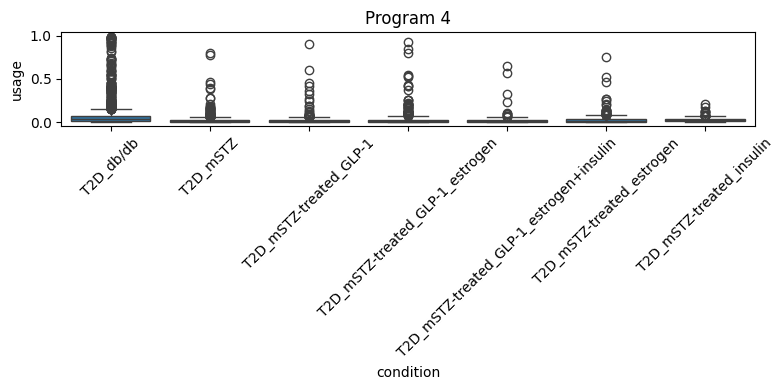

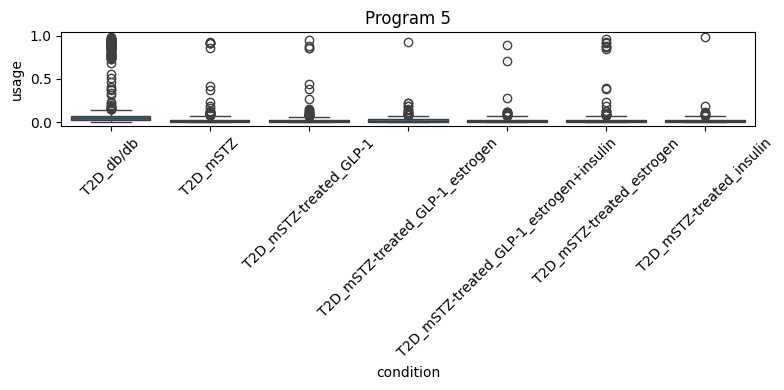

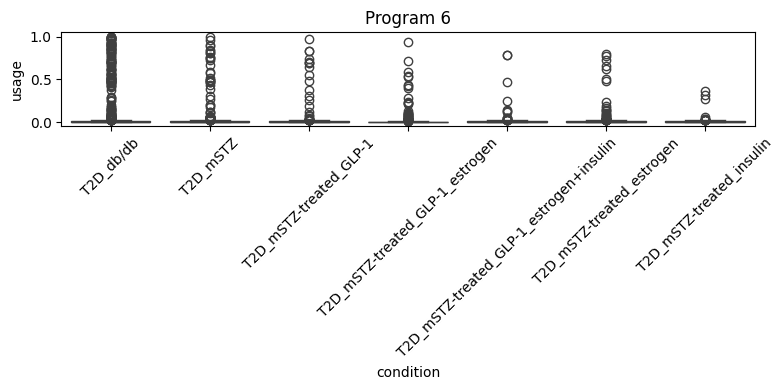

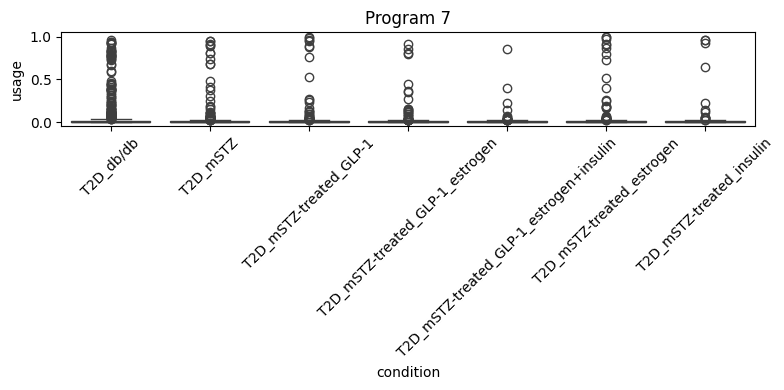

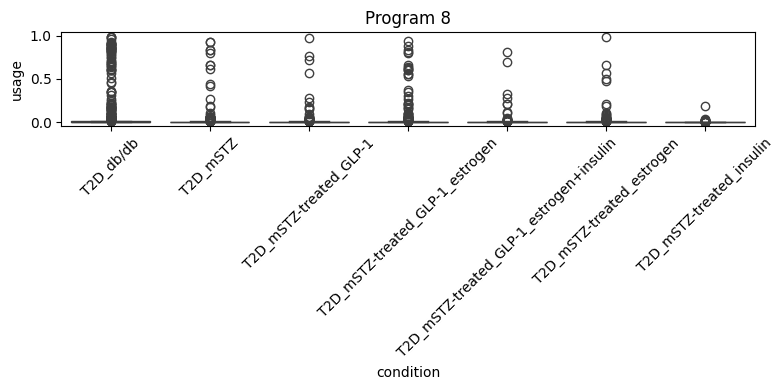

In [ ]:
# Condition 별로 특정 program이 up/down 되는지 확인
# 각 program별로 condition 간 차이를 시각화 + 통계 검정
for i in range(9):
    program_name = f"Program {i}"
    df = pd.DataFrame({
        "usage": adata.obsm["X_cnmf_norm"][:, i],
        "condition": adata.obs["condition"]
    })
    plt.figure(figsize=(8,4))
    sns.boxplot(data=df, x="condition", y="usage")
    plt.title(program_name)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 반응 프로그램 기반 의의 도출
# 이제 분석 결과를 기반으로 논리적인 메시지를 만들 수 있어:

# "GLP-1 treatment이 활성화시키는 program은 X이며, 이는 ER stress를 완화하는 유전자들로 구성됨"

# "Estrogen+Insulin 병합 치료는 program 4의 usage가 강하게 억제되며, 이 프로그램은 염증 관련 유전자 포함"

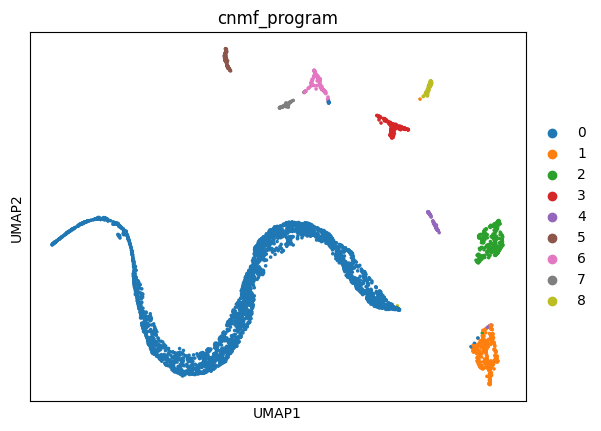

In [ ]:
# dominant program 기반 clustering (obs["cnmf_program"])
# 각 cell의 프로그램 사용 비율이 아닌 dominant program을 기준으로 cell에 label 붙임.

# usages = pd.read_csv("C:/Users/user/Desktop/T1D/t2d_treatment/cnmf_output/t2d_cnmf/t2d_cnmf.usages.k_9.dt_0_01.consensus.txt", sep="\t", index_col=0)

# 각 cell에서 가장 많이 쓰는 프로그램 번호 (argmax)
max_program = usages.values.argmax(axis=1)
adata.obs["cnmf_program"] = max_program.astype(str)

# UMAP 시각화
sc.pl.umap(adata, color="cnmf_program")

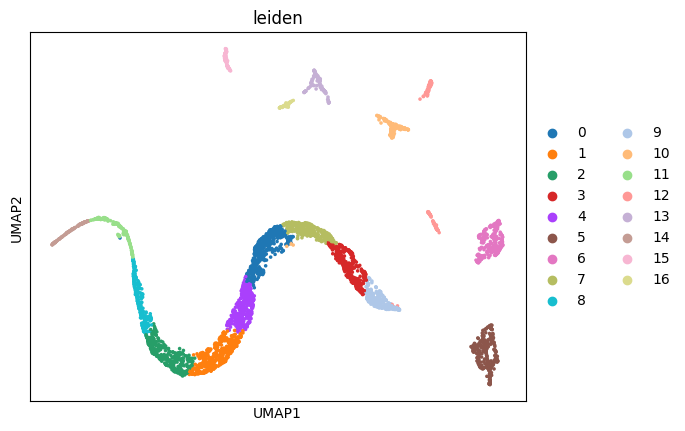

In [ ]:
# scanpy.tl.leiden()으로 clustering
sc.pp.neighbors(adata, use_rep="X_cnmf")  # 또는 X_pca
sc.tl.leiden(adata, resolution=0.5)  # 클러스터 결과가 adata.obs["leiden"]에 저장됨
sc.pl.umap(adata, color="leiden")

# -> 각 leiden cluster별로 대표적인 유전자를 봐서 cell type을 매핑

In [ ]:
# condition별 특이적인 program 통계검정 (ANOVA)
# 각 프로그램별로 condition 그룹 간 활성도 차이 통계적으로 검정

program_cols = [col for col in usages.columns if col.startswith("Program_")]

results = {}
for program in program_cols:
    # 각 condition별 활성도 리스트 만들기
    groups = [group[program].values for name, group in usages.groupby('condition')]
    stat, pval = f_oneway(*groups)
    results[program] = pval

# 유의한 프로그램만 필터링
significant = {k: v for k, v in results.items() if v < 0.05}
print("Significant programs (p < 0.05):")
for prog, pval in significant.items():
    print(f"{prog}: p={pval:.4e}")

# 유의한 프로그램만 출력 (p < 0.05)
significant = {k: v for k, v in results.items() if v < 0.05}
print("Significantly different programs across conditions:")
print(significant)

Significant programs (p < 0.05):
Program_1: p=3.9930e-135
Program_2: p=3.0347e-67
Program_3: p=1.2621e-23
Program_4: p=6.5697e-04
Program_5: p=1.2229e-56
Program_6: p=1.9077e-59
Program_7: p=5.1280e-21
Program_8: p=5.5470e-05
Program_9: p=1.7554e-13
Significantly different programs across conditions:
{'Program_1': np.float64(3.9930279086921173e-135), 'Program_2': np.float64(3.034720550127137e-67), 'Program_3': np.float64(1.2620979461540442e-23), 'Program_4': np.float64(0.0006569685485832286), 'Program_5': np.float64(1.2228878640055538e-56), 'Program_6': np.float64(1.9077351252035315e-59), 'Program_7': np.float64(5.1279523973755524e-21), 'Program_8': np.float64(5.546955038039485e-05), 'Program_9': np.float64(1.7554130719996854e-13)}


C:\Users\user\AppData\Local\Temp\ipykernel_2664\2088461821.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [group[program].values for name, group in usages.groupby('condition')]


In [52]:
# program 별 특징 유전자 확인
# spectra에 기반해서 해당 program의 top gene을 확인하고 해석 (gene ontology 등)

# spectra = pd.read_csv("C:/Users/user/Desktop/T1D/t2d_treatment/cnmf_output/t2d_cnmf/t2d_cnmf.gene_spectra_score.k_9.dt_0_01.txt", sep="\t", index_col=0)

spectra.index = [f"Program_{i}" for i in range(spectra.shape[0])]

all_top_genes = pd.DataFrame()   # 결과 저장용

# 각 프로그램별로 상위 20개 유전자 추출
for program in spectra.index:
    top_genes = spectra.loc[program].abs().nlargest(20)
    temp_df = pd.DataFrame({
        "Program": program,
        "Gene": top_genes.index,
        "Score": top_genes.values
    })
    all_top_genes = pd.concat([all_top_genes, temp_df], ignore_index=True)
    print(f"\nTop 20 genes for {program}:")
    print(top_genes)

# 저장
output_path = "C:/Users/user/Desktop/T1D/t2d_treatment/top20_genes_by_program.csv"
all_top_genes.to_csv(output_path, index=False)
print(f"\n저장 완료: {output_path}")

# 각 프로그램별로 가장 많이 기여한 유전자들 출력
# 이후 이 유전자 리스트를 가지고 GO 분석, 문헌 조회 등 수행


Top 20 genes for Program_0:
ENSMUSG00000027419    0.004520
ENSMUSG00000039278    0.004381
ENSMUSG00000021268    0.004248
ENSMUSG00000023236    0.004230
ENSMUSG00000033061    0.004213
ENSMUSG00000006651    0.004166
ENSMUSG00000021194    0.004155
ENSMUSG00000037852    0.004133
ENSMUSG00000015401    0.004108
ENSMUSG00000018339    0.003789
ENSMUSG00000074227    0.003766
ENSMUSG00000060802    0.003730
ENSMUSG00000002265    0.003642
ENSMUSG00000032181    0.003625
ENSMUSG00000027350    0.003530
ENSMUSG00000024990    0.003415
ENSMUSG00000022315    0.003411
ENSMUSG00000020077    0.003393
ENSMUSG00000050711    0.003382
ENSMUSG00000061808    0.003370
Name: Program_0, dtype: float64

Top 20 genes for Program_1:
ENSMUSG00000076498    0.003737
ENSMUSG00000002033    0.003650
ENSMUSG00000056290    0.003612
ENSMUSG00000032094    0.003603
ENSMUSG00000032093    0.003384
ENSMUSG00000020395    0.003240
ENSMUSG00000054892    0.003213
ENSMUSG00000076928    0.003111
ENSMUSG00000022148    0.003044
ENSMUSG0000

In [ ]:
# [확인] 출력 결과
all_top_genes

,Program,Gene,Score
0,Program_1,ENSMUSG00000027419,0.004520
1,Program_1,ENSMUSG00000039278,0.004381
2,Program_1,ENSMUSG00000021268,0.004248
3,Program_1,ENSMUSG00000023236,0.004230
4,Program_1,ENSMUSG00000033061,0.004213
...,...,...,...
175,Program_9,ENSMUSG00000018774,0.004380
176,Program_9,ENSMUSG00000018930,0.004333
177,Program_9,ENSMUSG00000023913,0.004332
178,Program_9,ENSMUSG00000058427,0.004175


C:\Users\user\AppData\Local\Temp\ipykernel_2664\1374057711.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_means = usage_df.groupby('treatment')[program_cols].mean()


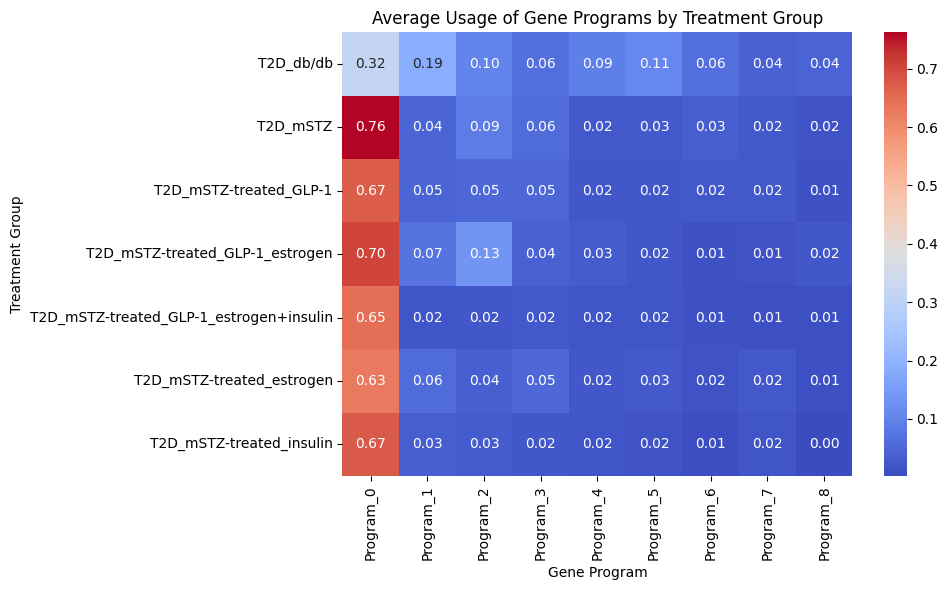

In [53]:
# T2D 내의 다양한 treatment group 간에 어떤 gene program이 더 활성화되었는가

# 프로그램 수 추출 (gene programs의 수)
k = adata.obsm["X_cnmf"].shape[1]

# usage_df 생성 (cell별 program 사용량)
usage_df = pd.DataFrame(
    adata.obsm["X_cnmf"],
    index=adata.obs_names,
    columns=[f"Program_{i}" for i in range(k)]
)

# treatment 조건 정보 붙이기
usage_df['treatment'] = adata.obs.loc[usage_df.index, 'condition']

# treatment별 평균 프로그램 사용량 계산
program_cols = usage_df.select_dtypes(include='number').columns
group_means = usage_df.groupby('treatment')[program_cols].mean()

# visulization
plt.figure(figsize=(10, 6))
sns.heatmap(group_means, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Average Usage of Gene Programs by Treatment Group")
plt.xlabel("Gene Program")
plt.ylabel("Treatment Group")
plt.tight_layout()
plt.show()
